In [1]:
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
import torch

from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,attn2map
from ithor_tools.map import single_scenemap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
gridSize=0.05
scene_name = "FloorPlan_Train8_1"
controller = Controller(
    agentMode="locobot",
    visibilityDistance=2.0,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderClassImage = True,
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderClassImage = True,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']

controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)



INFO - 2022-05-31 16:27:20,412 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


<ai2thor.server.Event at 0x7f045e990ac0
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
(98, 59)
(418, 713, 3)


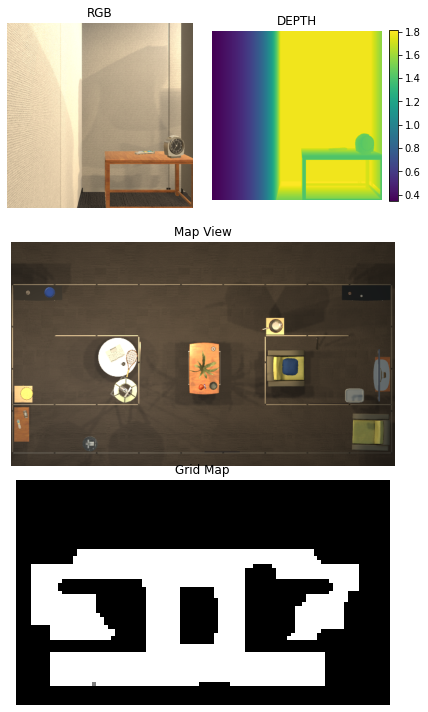

In [3]:
controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)

scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1)

pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import math

def to_rad(th):
    return th*math.pi / 180
    
class gridmap():
    def __init__(self,scenebound,stepsize=0.1):
        '''
        All of the unknown first
        '''
        scenebound = np.asarray(scenebound)
        x_max, z_max = np.max(scenebound,axis=0)
        x_min, z_min  = np.min(scenebound,axis=0)
        print(x_min,x_max,z_min,z_max)
        self.stepsize = stepsize
        x_max = self.stepsize* (x_max//self.stepsize)
        z_max = self.stepsize* (z_max//self.stepsize)
        x_min = self.stepsize* (x_min//self.stepsize +1)
        z_min = self.stepsize* (z_min//self.stepsize +1)

        x_len =  x_max- x_min
        z_len =  z_max- z_min
        # print(x_min,x_max,z_min,z_max)
        self.x_min, self.x_max = x_min, x_max
        self.z_min, self.z_max = z_min, z_max
        self.y_default = 0.90
        w_quan = int(x_len//self.stepsize)+1
        h_quan = int(z_len//self.stepsize)+1
        
        self.w_quan = w_quan
        self.h_quan = h_quan
        
        self.map = np.ones((w_quan,h_quan,3))/2
        width = 800
        height = 800
        fov = 60
        self.width = width
        self.height = height
        # camera intrinsics
        focal_length = 0.5 * width / math.tan(to_rad(fov/2))
        fx, fy, cx, cy = (focal_length,focal_length, width/2, height/2)
        self.intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, 
                                fx, fy, cx, cy)
                                

    def scan_single(self,controller,temp_map):
        agent_pos = controller.last_event.metadata['agent']['position']
        agent_rot = controller.last_event.metadata['agent']['rotation']
        DEPTH = controller.last_event.depth_frame
        COLOR = controller.last_event.frame
        GRAY = (np.sum(COLOR,axis=-1)/(3*255)).astype(np.float32)
        depth = o3d.geometry.Image(DEPTH)
        color = o3d.geometry.Image(GRAY)
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth,
                                                                    depth_scale=1.0,
                                                                    depth_trunc=2.0,
                                                                    convert_rgb_to_intensity=False)
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, self.intrinsic)
        pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
        
        rot = math.pi*agent_rot['y']/180
        pcd.transform([[-math.sin(rot), 0,-math.cos(rot), agent_pos['z']],
                [0, 1, 0, agent_pos['y']],
                [math.cos(rot), 0, -math.sin(rot), agent_pos['x']],
                [0, 0, 0, 1]])

        
        voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                                    voxel_size=self.stepsize)
        # print('voxelization')
        # o3d.visualization.draw_geometries([voxel_grid])

        voxels = voxel_grid.get_voxels()  # returns list of voxels
        # min_bound = voxel_grid.get_min_bound()
        # max_bound = voxel_grid.get_max_bound()
        # print(min_bound,max_bound)

        indices = np.stack(list(vx.grid_index for vx in voxels))
        shape = indices.max(axis=0)
        res = np.zeros((shape[2]+1,shape[0]+1))
        # print(max_map_pos,min_map_pos)
        for vx in voxels:
            grid_index = vx.grid_index
            pos_temp = voxel_grid.get_voxel_center_coordinate(grid_index)
            if grid_index[1] != 0 and grid_index[1]!= shape[1] and pos_temp[1]<1.2: # ceiling?
                res[grid_index[2],grid_index[0]] = 1
                map_pos = dict(x=pos_temp[2],y=pos_temp[1],z=pos_temp[0])
                map_pos = self.xyz2grid(map_pos)
                temp_map[map_pos[0],map_pos[1],:] = [0,0,0]
        # plt.figure()
        # plt.imshow(res)
        # plt.plot()
        return temp_map

    def scan_full(self,controller):
        pos = controller.last_event.metadata['agent']['position']
        temp_map = np.ones((self.w_quan,self.h_quan,3))/2
        grid_pos = self.xyz2grid(pos)
        temp_map= self.scan_single(controller,temp_map)
        temp_map[grid_pos[0],grid_pos[1]] = [1,0,1]
        for _ in range(5):
            controller.step(
                    action="RotateRight",degrees = 60
                )
            temp_map = self.scan_single(controller,temp_map)
        controller.step(
                    action="RotateRight",degrees = 60
                )
        for i in np.arange(start=-1,stop=1.01,step=0.01):
            temp_map = self.ray_x(grid_pos,temp_map,i) 
            temp_map = self.ray_y(grid_pos,temp_map,i) 
        self.merge_map(temp_map)
        return temp_map

    def ray_x(self,start_pos,temp_map,angle): # -1~1
        x_ = np.arange(start_pos[0]+1,start_pos[0]+2/self.stepsize).astype(np.int16)
        y_ = ((angle*(x_-start_pos[0]))+start_pos[1]).astype(np.int16)
        for x,y in zip(x_,y_):
            if temp_map[x,y,0]==0 or sum(temp_map[x-1:x,y,0]==0)>0:
                break
            else:
                temp_map[x,y] = [1,1,1]
                
        x_ = np.arange(start_pos[0]-1,start_pos[0]-2/self.stepsize,-1).astype(np.int16)
        y_ = ((angle*(x_-start_pos[0]))+start_pos[1]).astype(np.int16)
        for x,y in zip(x_,y_):
            if temp_map[x,y,0]==0 or  sum(temp_map[x:x+2,y,0]==0)>0:
                break
            else:
                temp_map[x,y] = [1,1,1]
        return temp_map

    def ray_y(self,start_pos,temp_map,angle): # -1~1
        y_ = np.arange(start_pos[1]+1,start_pos[1]+2/self.stepsize).astype(np.int16)
        x_ = ((angle*(y_-start_pos[1]))+start_pos[0]).astype(np.int16)
        for x,y in zip(x_,y_):
            if temp_map[x,y,0]==0 or sum(temp_map[x,y-1:y,0]==0)>0: #(temp_map[x,y-1,0]==0 and sum(temp_map[x-1:x+3,y,0]))>1:
                break
            else:
                temp_map[x,y] = [1,1,1]

        y_ = np.arange(start_pos[1]-1,start_pos[1]-2/self.stepsize,-1).astype(np.int16)
        x_ = ((angle*(y_-start_pos[1]))+start_pos[0]).astype(np.int16)
        for x,y in zip(x_,y_):
            if temp_map[x,y,0]==0 or sum(temp_map[x,y:y+2,0]==0)>0:
                break
            else:
                temp_map[x,y] = [1,1,1]
        return temp_map

    def merge_map(self,temp_map):
        free = np.where(temp_map==0)
        self.map[free] = 0
        occupied = np.where(temp_map==1)
        self.map[occupied] =1

    def xyz2grid(self,pos):
        x = pos['x']
        z = pos['z']
        w = int((x - self.x_min)//self.stepsize)
        h = int((z - self.z_min)//self.stepsize)
        return [w,h]

temp = gridmap(scene_bounds)

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789


(418, 713, 3)


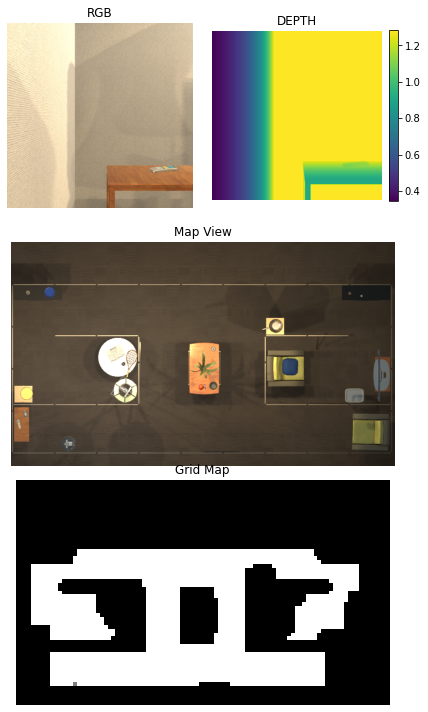

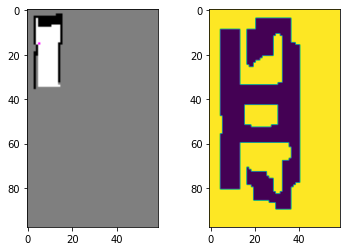

In [229]:
temp_map = temp.scan_full(controller)

pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(temp.map)
plt.subplot(1,2,2)
plt.imshow(sm.gridmap)
plt.show()

In [231]:
controller.step(
    action="Teleport",
    position = rstate[1200],
    rotation = dict(x=0,y=270,z=0)
)

temp_map= temp.scan_full(controller)
pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(temp_map)
plt.subplot(1,3,2)
plt.imshow(temp.map)
plt.subplot(1,3,3)
plt.imshow(sm.gridmap)
plt.show()